In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import dask.array as da
from datetime import datetime

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [ ]:
# product, time_reso, spatial_reso = 'CMORPH', '3h', '0.25'
product, time_reso, spatial_reso = 'IMERG', '1dy', '0.1'
# product, time_reso, spatial_reso = 'GSMaP', '3h', '0.1'
# product, time_reso, spatial_reso = 'MSWEP', '3h', '0.1'
# product, time_reso, spatial_reso = 'ERA5', '3h', '0.25'
# product, time_reso, spatial_reso = 'PERSIANN', '1dy', '0.25'

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : ERA5_3h.json
ACF function     : str
Number of threads: 25
Neighborhood area: 3x3



In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: ERA5_Italy_3h_2000_01_01_2023_12_31.nc


<xarray.Dataset> Size: 29MB
Dimensions:  (time: 32144, lat: 15, lon: 15)
Coordinates:
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float64 120B 47.5 47.25 47.0 46.75 ... 44.75 44.5 44.25 44.0
  * lon      (lon) float64 120B 10.0 10.25 10.5 10.75 ... 12.75 13.0 13.25 13.5
Data variables:
    PRE      (time, lat, lon) float32 29MB 0.02861 0.02766 0.01812 ... 0.0 0.0
Attributes:
    description:  ERA5 3 hours data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del PRE_veneto

In [8]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
# x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
time_vector_dt = pd.to_datetime(PRE_data_T['PRE']['time'].values)
DATA_RDY = xr.DataArray(PRE_data_T['PRE'],  coords={
                            'lon':PRE_data_T['lon'].values, 
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

In [37]:
lat_c = lat_ref[5]
lon_c = lon_ref[5]
print(lat_c,lon_c)

45.25 12.25


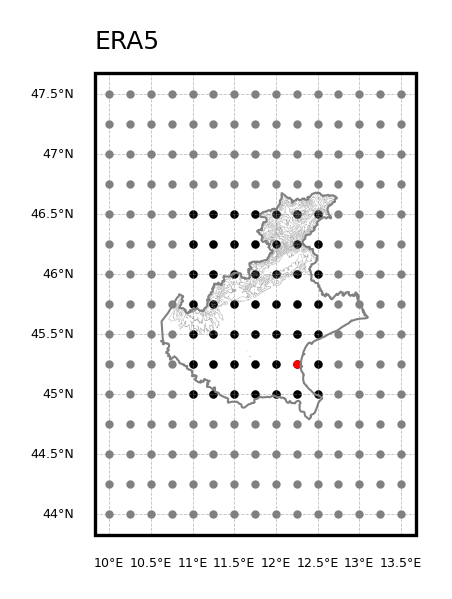

In [38]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
DEM.plot(facecolor='None',color='grey',alpha=0.6, ax=ax1, linewidth=0.1, zorder=10)

ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d_ref, lat2d_ref, s=1, c='k')
ax1.scatter(lon_c, lat_c, s=1, c='r')

ax1.set_title(product,fontsize=6,loc='left')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

In [39]:
npix = 3

if product == 'CMORPH':
    buffer = 0.50*npix*0.25
elif product == 'ERA5':
    buffer = 0.50*npix*0.25
elif product == 'IMERG':
    buffer = 0.25*npix*0.25
elif product == 'MSWEP':
    buffer = 0.25*npix*0.25
elif product == 'GSMaP':
    buffer = 0.25*npix*0.25
elif product == 'PERSIANN':
    buffer = 0.5*npix*0.25
else:
    buffer = 0.25*npix*0.25

In [40]:
Tr = np.array([5, 10, 20, 50, 100, 200])

eps = 1e-4
solat = lat_c - buffer + eps
nolat = lat_c + buffer + eps
ealon = lon_c + buffer + eps
welon = lon_c - buffer + eps
bcond = np.logical_and(
            np.logical_and( DATA_RDY.lat > solat, DATA_RDY.lat < nolat),
            np.logical_and( DATA_RDY.lon > welon, DATA_RDY.lon < ealon))

box_3h = DATA_RDY.where(bcond, drop = True).load()

In [41]:
xdata = box_3h.where(box_3h >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='24h').sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

In [ ]:
rcorr = DOWN_raw.grid_corr(xdaily, plot=True, thresh=1, cor_method='spearman')

In [62]:
L1 = DOWN_raw.area_lat_long(lat_c, lon_c, float(spatial_reso), float(spatial_reso))[0]

In [63]:
dcorr_MAR_genetic =  DOWN_raw.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf='mar',
                        use_ave=True, opt_method='genetic', toll=0.005,
                        plot=True)

# dcorr_MAR_lbfgsb =  DOWN_raw.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf='mar',
#                         use_ave=True, opt_method='lbfgsb', toll=0.005,
#                         plot=True)

differential_evolution step 1: f(x)= 0.004657188576539945
differential_evolution step 2: f(x)= 0.004640344288679011
differential_evolution step 3: f(x)= 0.004637984478959157
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [64]:
dcorr_STR_genetic =  DOWN_raw.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf='str',
                        use_ave=True, opt_method='genetic', toll=0.005,
                        plot=True)

# dcorr_STR_lbfgsb =  DOWN_raw.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf='str',
#                         use_ave=True, opt_method='lbfgsb', toll=0.005,
#                         plot=True)

differential_evolution step 1: f(x)= 0.005085677585462168
differential_evolution step 2: f(x)= 0.005085677585462168
differential_evolution step 3: f(x)= 0.005085677585462168
differential_evolution step 4: f(x)= 0.005085677585462168
differential_evolution step 5: f(x)= 0.005027349358921421
differential_evolution step 6: f(x)= 0.004816967973930135
differential_evolution step 7: f(x)= 0.004664505345719202
differential_evolution step 8: f(x)= 0.004664505345719202
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [65]:
x = np.arange(rcorr['vdist'].min(),rcorr['vdist'].max())

MAR = DOWN_raw.epl_fun(x,rcorr['eps_s'],rcorr['alp_s'])
# MAR_DOWN_lbfgsb = DOWN_raw.epl_fun(x,dcorr_MAR_lbfgsb['eps_d'],dcorr_MAR_lbfgsb['alp_d'])
MAR_DOWN_genetic = DOWN_raw.epl_fun(x,dcorr_MAR_genetic['eps_d'],dcorr_MAR_genetic['alp_d'])

STR = DOWN_raw.str_exp_fun(x,rcorr['d0_s'],rcorr['mu0_s'])
# STR_DOWN_lbfgsb = DOWN_raw.str_exp_fun(x,dcorr_STR_lbfgsb['d0_d'],dcorr_STR_lbfgsb['mu0_d'])
STR_DOWN_genetic = DOWN_raw.str_exp_fun(x,dcorr_STR_genetic['d0_d'],dcorr_STR_genetic['mu0_d'])

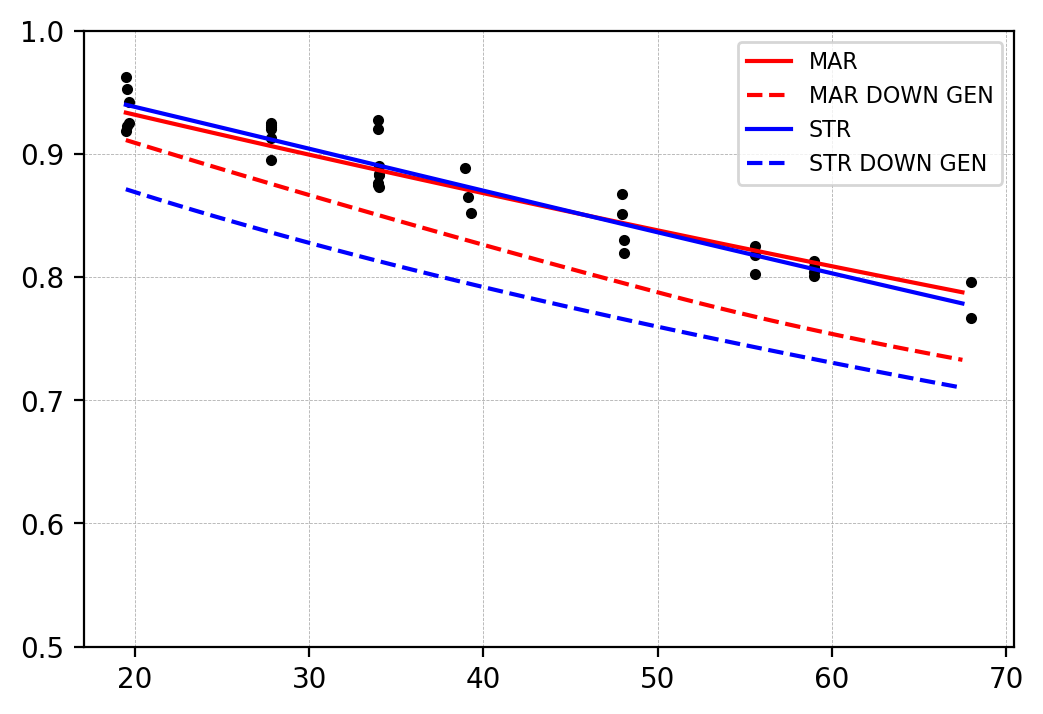

In [60]:
fig = plt.figure(figsize=(6,4),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(rcorr['vdist'],rcorr['vcorr'],'.k')

ax1.plot(x,MAR,'-r',label='MAR')
# ax1.plot(x,MAR_DOWN_lbfgsb,'--r',label='MAR DOWN LBF')
ax1.plot(x,MAR_DOWN_genetic,linestyle='--',color='r',label='MAR DOWN GEN')

ax1.plot(x,STR,'-b',label='STR')
# ax1.plot(x,STR_DOWN_lbfgsb,'--b',label='STR DOWN LBF')
ax1.plot(x,STR_DOWN_genetic,linestyle='--',color='b',label='STR DOWN GEN')

ax1.set_ylim(0.5,1)
ax1.legend(fontsize=8)
ax1.grid(linewidth=0.3,linestyle='--')